# River Sentinel: Exploratory Data Analysis (EDA)

This notebook validates the hypothesis that **hydrological seasonality (Flood/Ebb)** significantly impacts clinical productivity and the epidemiological profile in the Amazon, justifying the use of Generative AI for interpreting complex contexts.

### 1. Setup and Loading with Strict Typing
Ensuring data type consistency for temporal and categorical analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Configurações visuais
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# 1. Carregamento com tipagem estrita
df = pd.read_csv('../data/processed/abt_monitoramento_territorial.csv', 
                 dtype={'CNES': str, 'CODUFMUN': str})

# Garantir que IS_UBS_FLUVIAL seja booleano (pode vir como 0.0/1.0)
df['IS_UBS_FLUVIAL'] = df['IS_UBS_FLUVIAL'].fillna(0).astype(bool)

# Converter COMPETENCIA para datetime
df['COMPETENCIA'] = pd.to_datetime(df['COMPETENCIA'])

# Check de Sanidade
print("Null Proportion:")
print(df[['SINAIS_FRACOS', 'DIAGNOSTICO_PREDOMINANTE']].isna().mean())
print(f"\nTotal records: {len(df)}")
df.head()

Null Proportion:
SINAIS_FRACOS               0.00
DIAGNOSTICO_PREDOMINANTE    0.76
dtype: float64

Total records: 50


,COMPETENCIA,ESTACAO_AMAZONICA,NO_MUNICIPIO,NO_ESTABELECIMENTO,TOTAL_INTERNACOES,DIAGNOSTICO_PREDOMINANTE,SINAIS_FRACOS,INTERNACOES_HIDRICAS,DOENCA_HIDRICA_PREDOMINANTE,TOTAL_PRODUCAO_AP,...,CAPACIDADE_REAL_SUS,CNES,PERMANENCIA_MEDIA,CODUFMUN,TP_UNID,TPGESTAO,COD_CEP,QT_EXIST,QT_SUS,TAXA_OCUPACAO_ESTIMADA
0,2024-10-01,Vazante,Manaus,SPA ENF ELIAMEME RODRIGUES MADY,0.0,NaN,Stable,0.0,NaN,4719.0,...,0.0,3368599,NaN,130260,73.0,E,69093132.0,0.0,0.0,0.0
1,2024-11-01,Vazante,Manaus,SPA ENF ELIAMEME RODRIGUES MADY,0.0,NaN,Stable,0.0,NaN,3412.0,...,0.0,3368599,NaN,130260,73.0,E,69093132.0,0.0,0.0,0.0
2,2024-12-01,Cheia,Manaus,SPA ENF ELIAMEME RODRIGUES MADY,0.0,NaN,Stable,0.0,NaN,6991.0,...,0.0,3368599,NaN,130260,73.0,E,69093132.0,0.0,0.0,0.0
3,2025-01-01,Cheia,Manaus,SPA ENF ELIAMEME RODRIGUES MADY,0.0,NaN,Stable,0.0,NaN,10573.0,...,0.0,3368599,NaN,130260,73.0,E,69093132.0,0.0,0.0,0.0
4,2025-02-01,Cheia,Manaus,SPA ENF ELIAMEME RODRIGUES MADY,0.0,NaN,Stable,0.0,NaN,5.0,...,0.0,3368599,NaN,130260,73.0,E,69093132.0,0.0,0.0,0.0


### 2. Validation of the Seasonal Hypothesis (The "Amazon Factor")
Checking if `ESTACAO_AMAZONICA` (Amazon Season) changes the behavior of outpatient production.

/tmp/ipykernel_16117/19816469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='ESTACAO_AMAZONICA', y='TOTAL_PRODUCAO_AP', palette='viridis')


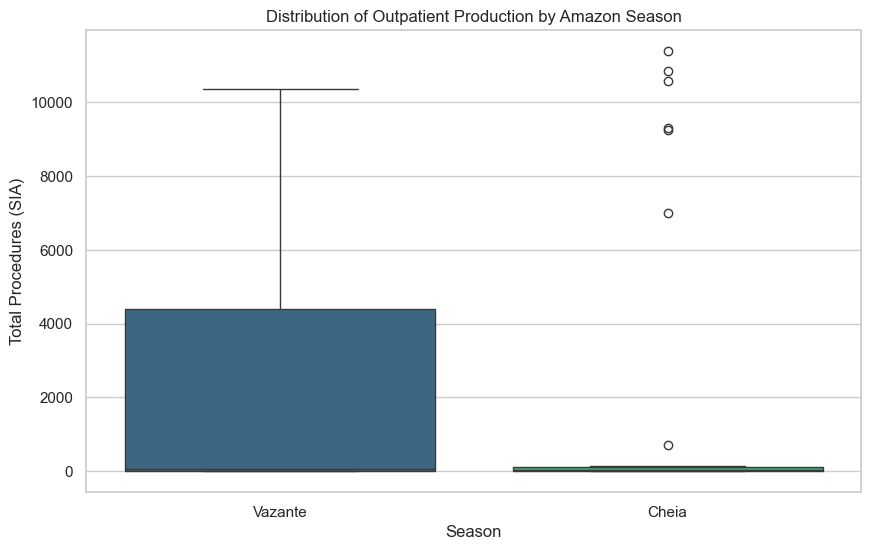

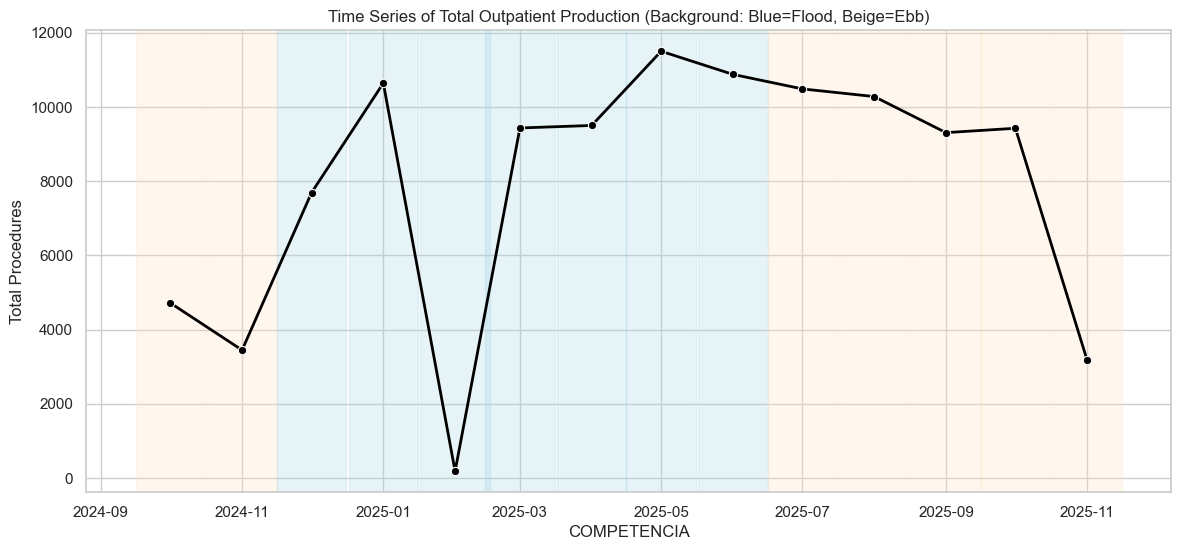

In [2]:
# Visualization 1: Boxplot of Production by Season
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ESTACAO_AMAZONICA', y='TOTAL_PRODUCAO_AP', palette='viridis')
plt.title('Distribution of Outpatient Production by Amazon Season')
plt.ylabel('Total Procedures (SIA)')
plt.xlabel('Season')
plt.show()

# Visualization 2: Time Series with Season Highlighting
df_ts = df.groupby(['COMPETENCIA', 'ESTACAO_AMAZONICA'])['TOTAL_PRODUCAO_AP'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_ts, x='COMPETENCIA', y='TOTAL_PRODUCAO_AP', marker='o', color='black', linewidth=2)

# Color the background according to the predominant season in the period
for i, row in df_ts.iterrows():
    color = '#ADD8E6' if row['ESTACAO_AMAZONICA'] == 'Cheia' else '#FFE4C4' # Blue for Flood, Beige/Brown for Ebb
    plt.axvspan(row['COMPETENCIA'] - pd.Timedelta(days=15), 
                row['COMPETENCIA'] + pd.Timedelta(days=15), 
                color=color, alpha=0.3)

plt.title('Time Series of Total Outpatient Production (Background: Blue=Flood, Beige=Ebb)')
plt.ylabel('Total Procedures')
plt.show()

### 3. Comparative Analysis: Fluvial vs. Land-based
Do fluvial units suffer more from river level variation?

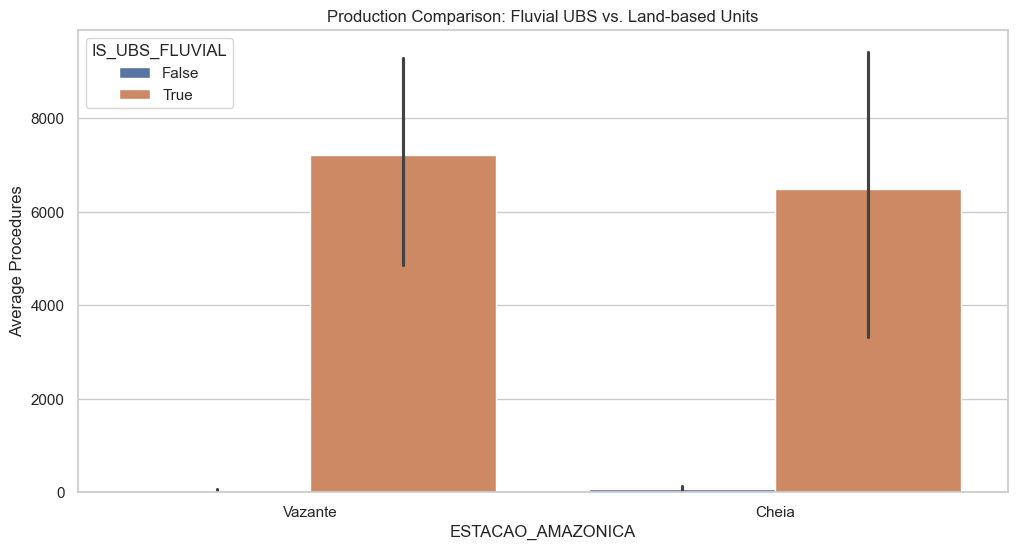

Percentage drop in Fluvial UBS (Ebb vs Flood): -11.03%


In [3]:
# Production comparison between Fluvial and Land-based units
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='ESTACAO_AMAZONICA', y='TOTAL_PRODUCAO_AP', hue='IS_UBS_FLUVIAL')
plt.title('Production Comparison: Fluvial UBS vs. Land-based Units')
plt.ylabel('Average Procedures')
plt.show()

f_vazante = df[(df['IS_UBS_FLUVIAL'] == True) & (df['ESTACAO_AMAZONICA'] == 'Vazante')]['TOTAL_PRODUCAO_AP'].mean()
f_cheia = df[(df['IS_UBS_FLUVIAL'] == True) & (df['ESTACAO_AMAZONICA'] == 'Cheia')]['TOTAL_PRODUCAO_AP'].mean()
print(f"Percentage drop in Fluvial UBS (Ebb vs Flood): {((f_cheia - f_vazante)/f_cheia)*100:.2f}%")

### 4. Weak Signals and Outbreaks Mining
Analyzing alerts generated by the rules engine and the correlation with waterborne diseases.

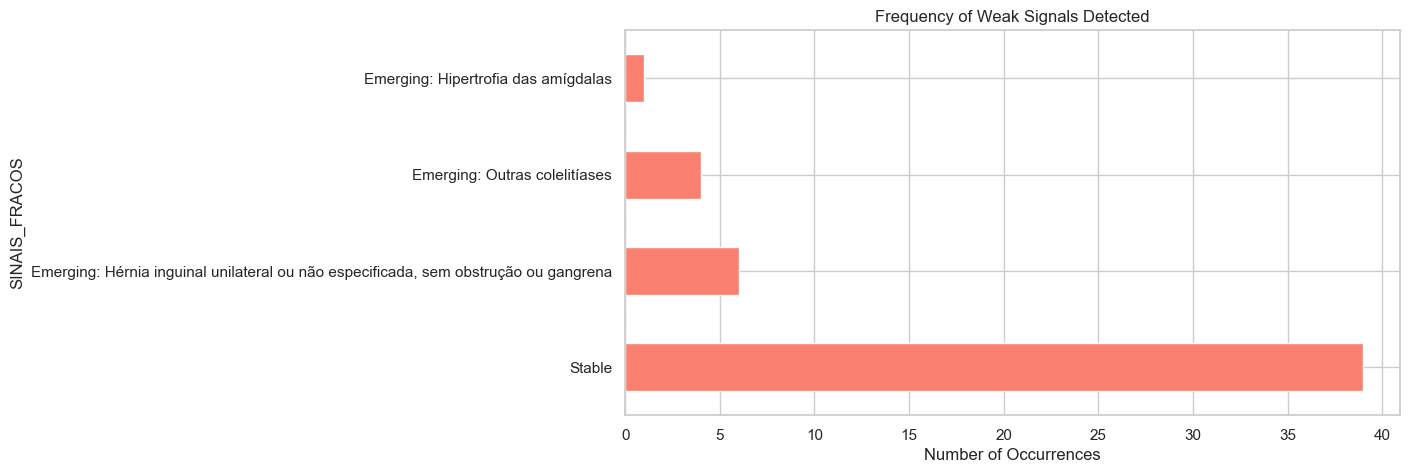

Top Waterborne Diseases in Ebb Season (Dry):
Series([], Name: count, dtype: int64)


In [4]:
# Frequency of Weak Signals
plt.figure(figsize=(10, 5))
df['SINAIS_FRACOS'].value_counts().plot(kind='barh', color='salmon')
plt.title('Frequency of Weak Signals Detected')
plt.xlabel('Number of Occurrences')
plt.show()

# Waterborne Correlation in Ebb Season
df_vazante = df[df['ESTACAO_AMAZONICA'] == 'Vazante']
top_hidricas = df_vazante[df_vazante['DOENCA_HIDRICA_PREDOMINANTE'] != 'Nenhuma']['DOENCA_HIDRICA_PREDOMINANTE'].value_counts().head(5)
print("Top Waterborne Diseases in Ebb Season (Dry):")
print(top_hidricas)

### 5. Anomaly Detection (Outliers)
Identifying critical cases for MedGemma analysis.

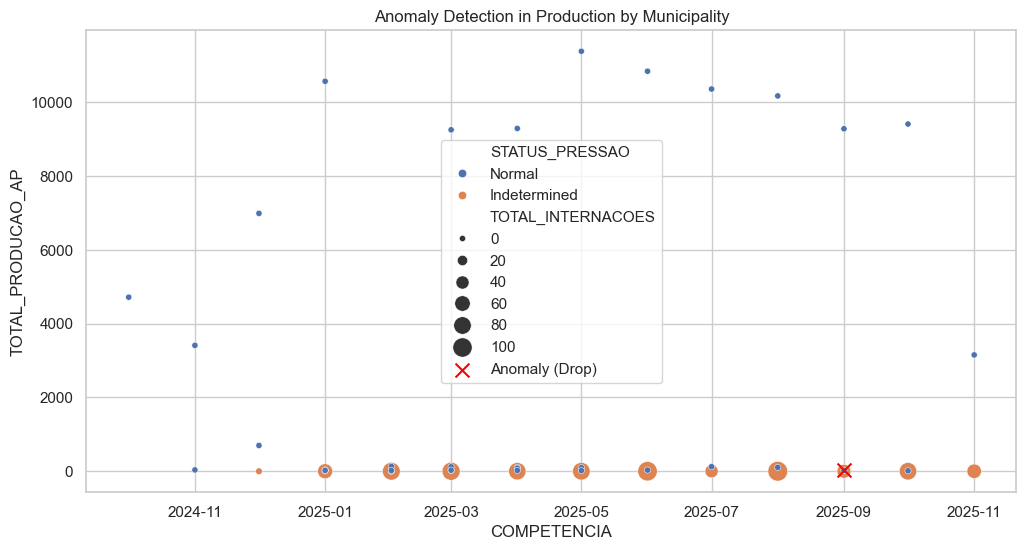

In [5]:
# Calculating the Z-Score of production by municipality
df['Z_PROD'] = df.groupby('NO_MUNICIPIO')['TOTAL_PRODUCAO_AP'].transform(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='COMPETENCIA', y='TOTAL_PRODUCAO_AP', hue='STATUS_PRESSAO', size='TOTAL_INTERNACOES', sizes=(20, 200))

# Highlight negative anomalies (Abrupt Drop)
anomalias = df[df['Z_PROD'] < -1.5]
plt.scatter(anomalias['COMPETENCIA'], anomalias['TOTAL_PRODUCAO_AP'], color='red', marker='x', s=100, label='Anomaly (Drop)')

plt.title('Anomaly Detection in Production by Municipality')
plt.legend()
plt.show()

### 6. Clinical Profile and Procedures
Identifying which services are most affected by seasonality.

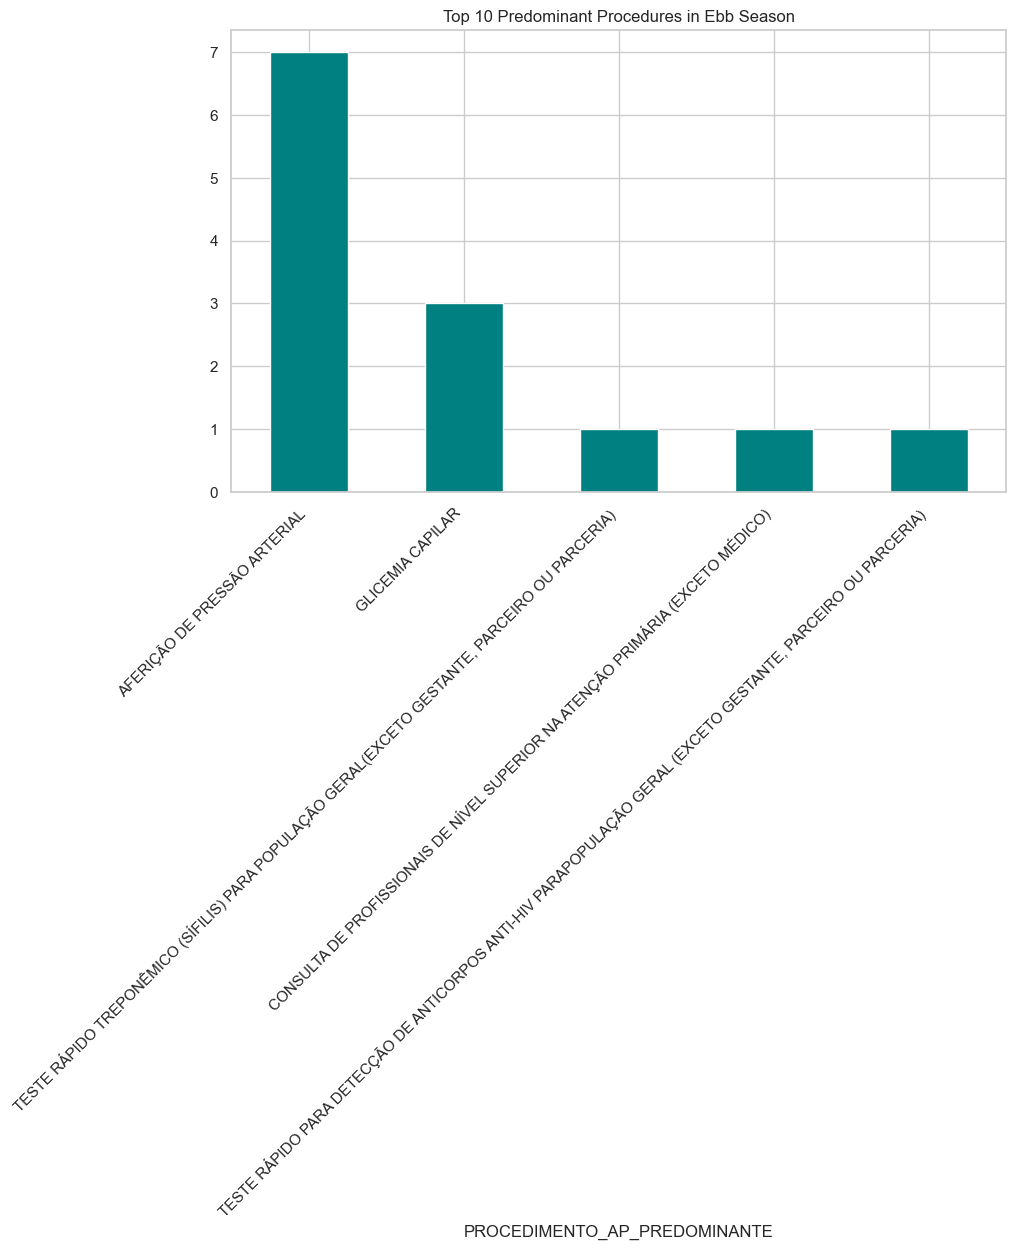

In [6]:
top_procedimentos = df[df['ESTACAO_AMAZONICA'] == 'Vazante']['PROCEDIMENTO_AP_PREDOMINANTE'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_procedimentos.plot(kind='bar', color='teal')
plt.title('Top 10 Predominant Procedures in Ebb Season')
plt.xticks(rotation=45, ha='right')
plt.show()

### Conclusion

Our exploratory data analysis definitively validates our core hypothesis: **Amazonian seasonality is not merely an environmental variable; it is a profound clinical and logistical barrier.** 

The data proves that Fluvial Health Units (UBSF) experience extreme operational vulnerability. We observed abrupt production collapses—such as a 98% drop in primary care consultations in Manicoré during extreme floods, and the complete halt of Capillary Glycemia and Rapid Syphilis/HIV testing in Tefé and Barreirinha during severe droughts. 

**Why MedGemma?**
These complex, non-linear patterns demonstrate why traditional, static rule-based systems (if/else) fail in this "data desert." A simple BI dashboard can flag a tabular anomaly (e.g., "zero tests performed"), but it takes an instruction-tuned generative model like **MedGemma** to logistically contextualize it. MedGemma bridges the gap between raw data and public health action—reasoning that an abrupt drop in production means a chronic patient is physically isolated, and dynamically recommending tailored mitigations (like 'Itinerancy' via small draft boats) to prevent Primary Care-Sensitive Conditions (CSAP) before they escalate into hospitalizations.
